# Using Centroids to Filter Ookla Performance Tiles and Aggregating Loaded Latency

This tutorial will show how to filter Ookla Global Performance Map Tiles to a specific area by using centroid coordinates.

The R version of this tutorial can be found [here](https://www.ookla.com/articles/ookla-for-good-centroid-coordinates).

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Download data

We will be using the state of Texas for this example.

In [2]:
STATE_FIPS_TEXAS = '48'
TIGER_COUNTIES_URL = "https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/tl_2022_us_county.zip"

#Ookla data
def get_perf_tiles_parquet_url(service: str, year: int, quarter: int) -> str:
    quarter_start = f"{year}-{(((quarter - 1) * 3) + 1):02}-01"
    url = f"s3://ookla-open-data/parquet/performance/type={service}/year={year}/quarter={quarter}/{quarter_start}_performance_{service}_tiles.parquet"
    return url


# Zipfile of U.S. county boundaries
counties = gpd.read_file(TIGER_COUNTIES_URL)
# Filter out the Texas fips code and reproject to match the tiles
state_counties_gdf = counties.loc[counties['STATEFP'] == STATE_FIPS_TEXAS].to_crs(4326)
# Capture the total bounds of the state's counties
state_bounds = state_counties_gdf.total_bounds

We'll also establish our metric name that we'll use later on. In this case we're focusing on average download latency (which is in milliseconds). 

In [3]:
metric_name = 'avg_lat_down_ms'
perf_tiles_url = get_perf_tiles_parquet_url("fixed", 2023, 2)

## Filter data using a bounding box of specified area

We'll create the box using the state boundaries from earlier.

In [4]:
bbox_filters = [('tile_y', '<=', state_bounds[3]), ('tile_y', '>=', state_bounds[1]),
                ('tile_x', '<=', state_bounds[2]), ('tile_x', '>=', state_bounds[0])]

The most crucial step: by only specifying the columns we need and filtering, this loads only the data we care about in a very performant fashion.

In [5]:
tiles_df = pd.read_parquet(perf_tiles_url,
                           columns=['tile_x', 'tile_y', 'tests', metric_name],
                           filters=bbox_filters,
                           storage_options={"s3": {"anon": True}}
                           )

We can now establish a geodataframe with the subset of OFG tile data. 

In [6]:
tiles_gdf = gpd.GeoDataFrame(tiles_df, geometry=gpd.points_from_xy(tiles_df.tile_x, tiles_df.tile_y), crs="EPSG:4326").drop(columns=["tile_x", "tile_y"])
# Drop any rows where we're missing values for the metric
tiles_gdf.dropna(subset=[metric_name], inplace=True)

## Perform a spatial join to counties of Texas

Now that the dataset is smaller, this join will be easier to perfom. We purposefully use an inner join to only keep tiles that intersect with counties. We'll add the county polygons back in later.

In [7]:
counties_tiles_gdf = gpd.sjoin(tiles_gdf, state_counties_gdf, how="inner", predicate="intersects")[['GEOID', 'tests', metric_name]]

## Aggregating Loaded Latency
With the dataset we created, we can now perform analysis as needed. With this example we thought to demonstrate aggregating loaded latency, since it is a recently added metric.

Group by county and calculate the weighted average of the metric.

In [ ]:
county_stats = (
    counties_tiles_gdf.groupby(["GEOID"])
    .apply(
        lambda x: pd.Series(
            {"avg_metric_wt": np.average(x[metric_name], weights=x["tests"])}
        )
    )
    .reset_index()
)

Re-merge the county polygon geometries to our data so we can visualize it

In [10]:
county_data = state_counties_gdf[['GEOID', 'geometry']].merge(county_stats, on='GEOID').to_crs(counties.crs.to_epsg())

"Cut" the data into buckets for visualization.

In [11]:
labels = ["0 to 300", "300 to 350", "350 to 400", "400 to 450", "450+"]
county_data['group'] = pd.cut(
    county_data['avg_metric_wt'],
    bins=(0, 300, 350, 400, 450, 10000),
    right=False,
    labels=labels
)

Plot the map.

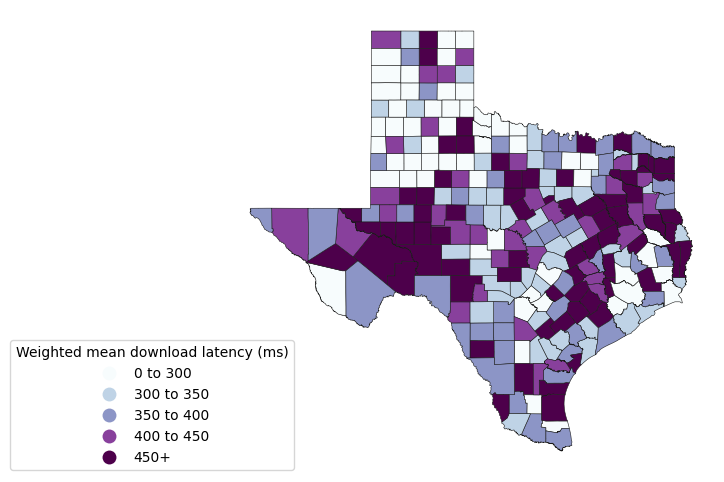

fin


In [12]:
fig, ax = plt.subplots(1, figsize=(10, 6))
county_data.plot("group", ax=ax, cmap="BuPu", linewidth=0.4, edgecolor="0.1", legend=True,)
ax.set_axis_off()

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.15, 0.3))
leg.set_title("Weighted mean download latency (ms)")

plt.show()

print("fin")